In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm

from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

import pymaster as nmt

import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

import lmfit 

# Full sky

In [2]:
nside = 64

sky = get_sky(nside, 'd0s0')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)


pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")


########################################################################################################

# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]

U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


(49152,)

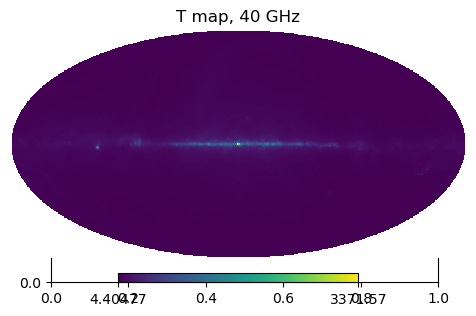

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))
hp.mollview(I40, title='T map, 40 GHz', fig=fig.number)

# Sky Patch
Extracting a patch of the sky and converting 1D -> 2D

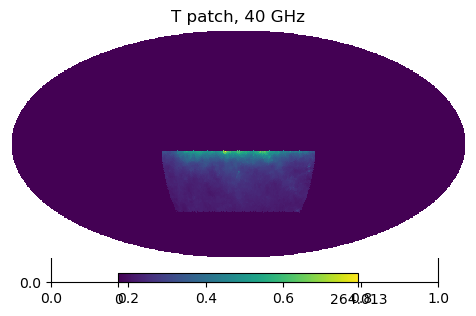

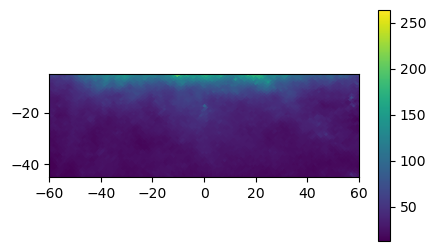

In [4]:
RA1 = -60 
RA2 = 60
dec1 = -45
dec2 = -5


idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)


map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    #visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0
    
########################################################################################

maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']



for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}" 
        
        
        map_data = globals()[map_name]
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        

        variable_prefix = f"{map_type}{band}"
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp 
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp

#####################################################################################################
fig, ax = plt.subplots(figsize=(5, 3))
hp.mollview(I40, title='T patch, 40 GHz', fig=fig.number)



plt.figure(figsize=(5, 3))
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()

In [5]:
'''
for i in range(len(I40)):
    if I40[i] == 0:
        I40[i] = hp.UNSEEN
        
fig, ax = plt.subplots(figsize=(5, 3))
hp.mollview(I40, title='T patch, 40 GHz', fig=fig.number)
'''

"\nfor i in range(len(I40)):\n    if I40[i] == 0:\n        I40[i] = hp.UNSEEN\n        \nfig, ax = plt.subplots(figsize=(5, 3))\nhp.mollview(I40, title='T patch, 40 GHz', fig=fig.number)\n"

### Convert 1D -> 2D

In [6]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  


import random
num_simulations_beam = 2
num_simulations_angle = 3


frequencies = [40, 60, 78, 100, 140, 195, 280, 402]

I_maps = {
    40: maps_2d['mp_hp_I40'], 60: maps_2d['mp_hp_I60'], 78: maps_2d['mp_hp_I78'],
    100: maps_2d['mp_hp_I100'], 140: maps_2d['mp_hp_I140'], 195: maps_2d['mp_hp_I195'],
    280: maps_2d['mp_hp_I280'], 402: maps_2d['mp_hp_I402']}


Q_maps = {
    40: maps_2d['mp_hp_Q40'], 60: maps_2d['mp_hp_Q60'], 78: maps_2d['mp_hp_Q78'],
    100: maps_2d['mp_hp_Q100'], 140: maps_2d['mp_hp_Q140'], 195: maps_2d['mp_hp_Q195'],
    280: maps_2d['mp_hp_Q280'], 402: maps_2d['mp_hp_Q402']}

U_maps = {
    40: maps_2d['mp_hp_U40'], 60: maps_2d['mp_hp_U60'], 78: maps_2d['mp_hp_U78'],
    100: maps_2d['mp_hp_U100'], 140: maps_2d['mp_hp_U140'], 195: maps_2d['mp_hp_U195'],
    280: maps_2d['mp_hp_U280'], 402: maps_2d['mp_hp_U402']}

393 131


In [7]:
print(f"Patch with dimensions {Nx * pix_size_deg} x {Ny * pix_size_deg} degrees")


Patch with dimensions 360.0389759584641 x 120.0129919861547 degrees


In [8]:
Nx

393

In [9]:
Ny

131

In [10]:
pix_size

54.96778258907849

In [11]:
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)


Q_flat_all = {}
U_flat_all = {}
I_flat_all = {}

for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    I_map = I_maps[freq]
    
    Q_map_flat  = np.zeros((I40.shape))
    U_map_flat  = np.zeros((I40.shape))
    I_map_flat  = np.zeros((I40.shape))
    

    new_map_I = np.zeros_like(I40) 
    new_map_I[idx] = I_maps[freq].flatten()
    I_map_flat = new_map_I  # Store the new map in the flat array
        
   
    new_map_Q = np.zeros_like(I40) 
    new_map_Q[idx] = Q_maps[freq].flatten()
    Q_map_flat = new_map_Q  # Store the new map in the flat array
        
        
    new_map_U = np.zeros_like(I40) 
    new_map_U[idx] = U_maps[freq].flatten()
    U_map_flat = new_map_U
        
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat 
    I_flat_all[freq] = I_map_flat
    
    
    
n_pixels   = I40.size
full_array = np.zeros((len(frequencies), 2, n_pixels)) #3


for f_idx, freq in enumerate(frequencies):
    Q_stack = Q_flat_all[freq]
    U_stack = U_flat_all[freq]
    
   
    freq_stack = np.stack([Q_stack, U_stack], axis=0)  # I_expanded


    full_array[f_idx] = freq_stack


print(full_array.shape)  # Expected shape: (8, 2, 4, 5, 49152)

# different shape
#full_array = full_array.transpose(2, 3, 0, 1, 4)
#print(full_array.shape)  # Expected shape: (4, 5, 8, 2, 49152)

(8, 2, 49152)


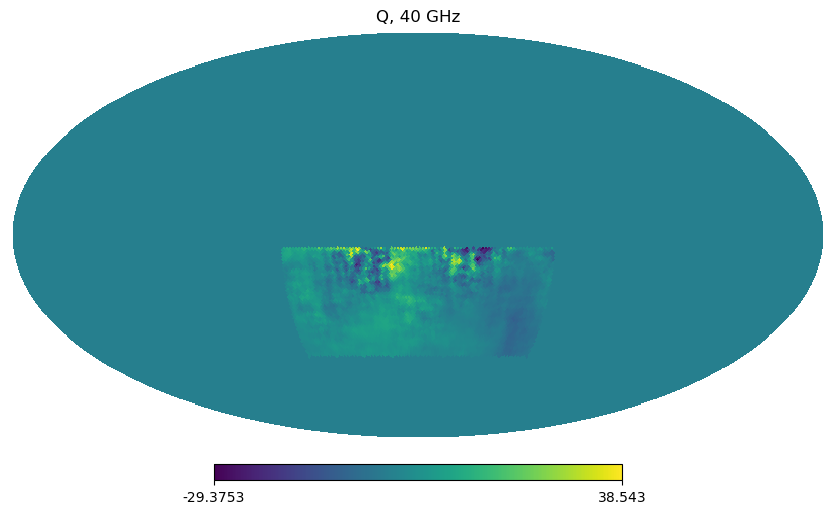

In [12]:
# Q map, 40 GHz
hp.mollview(full_array[0][0], title=f'Q, 40 GHz')

# Component Separation

In [13]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
instrument_freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch


In [14]:
components = [CMB(), Dust(350.), Synchrotron(20.)]
results = []
cmb_Q = {}
cmb_U = {}
cmb_I = {}


result = basic_comp_sep(components, instrument_freq, full_array)
results.append(result)

print(result.x)
print('\n')

cmb_Q = result.s[0, 0] # 0
cmb_U = result.s[0, 1] # 1
#cmb_I[i][j] = result.s[0, 0]

[ 1.53999992 20.         -3.        ]




In [15]:
'''
for i in range(len(result.s[0,1])):
    if result.s[0,1][i] == 0:
        result.s[0,1][i] = hp.UNSEEN
    if result.s[1,1][i] == 0:
        result.s[1,1][i] = hp.UNSEEN
    if result.s[2,1][i] == 0:
        result.s[2,1][i] = hp.UNSEEN



plt.figure(figsize=(18, 3))

hp.mollview(result.s[0,1], title='CMB - Q', sub=(1, 3, 1))
hp.mollview(result.s[1,1], title='Dust - Q', norm='hist', sub=(1, 3, 2))
hp.mollview(result.s[2,1], title='Synchrotron - Q', norm='hist', sub=(1, 3, 3))
'''

"\nfor i in range(len(result.s[0,1])):\n    if result.s[0,1][i] == 0:\n        result.s[0,1][i] = hp.UNSEEN\n    if result.s[1,1][i] == 0:\n        result.s[1,1][i] = hp.UNSEEN\n    if result.s[2,1][i] == 0:\n        result.s[2,1][i] = hp.UNSEEN\n\n\n\nplt.figure(figsize=(18, 3))\n\nhp.mollview(result.s[0,1], title='CMB - Q', sub=(1, 3, 1))\nhp.mollview(result.s[1,1], title='Dust - Q', norm='hist', sub=(1, 3, 2))\nhp.mollview(result.s[2,1], title='Synchrotron - Q', norm='hist', sub=(1, 3, 3))\n"

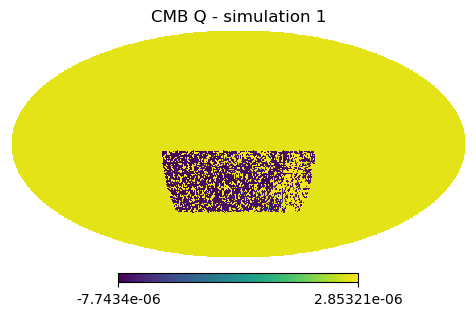

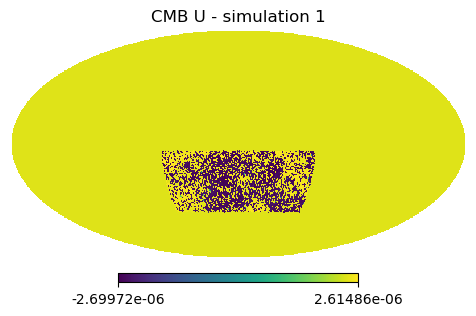

In [16]:
plt.figure(figsize=(5, 3))
hp.mollview(cmb_Q, title='CMB Q - simulation 1', norm='hist', fig=fig.number)
plt.show()

plt.figure(figsize=(5, 3))
hp.mollview(cmb_U, title='CMB U - simulation 1', norm='hist', fig=fig.number)
plt.show()

#plt.figure(figsize=(5, 3))
#hp.mollview(cmb_I[0][0], title='CMB T - simulation 1', norm='hist', fig=fig.number)
#plt.show()


### Convert 1D -> 2D

In [17]:
cmb_Q_2d = {}
cmb_U_2d = {}
cmb_I_2d = {}

def safe_convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan):
    if data.size == 0:
        raise ValueError("Input data is empty.")
    
    reproj_map, ra_hp, dec_hp = convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan)
    
    if np.isnan(reproj_map).all():
        raise ValueError("Reprojected map is all NaNs.")
    
    return reproj_map, ra_hp, dec_hp


cmb_Q_2d, ra_hp, dec_hp = safe_convert2grid(cmb_Q, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d, ra_hp, dec_hp = safe_convert2grid(cmb_U, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        

# POWER SPECTRA 
Using Namaster

In [18]:
pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(cmb_Q_2d)

# bins


l0_bins = np.arange(Nx/8) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/X_width_rad


b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

TT_PS = {}
BB_PS = {}
EE_PS = {}


        
#I = I_deconv[i][j]
Q = cmb_Q_2d
U = cmb_U_2d
        
f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q, U], purify_b=True)
        #f0 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I])
        
        #w00 = nmt.NmtWorkspaceFlat()
        #w00.compute_coupling_matrix(f0, f0, b)
        #w02 = nmt.NmtWorkspaceFlat()
        #w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f2, f2, b)
   
cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    
        #cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
        #cl00_uncoupled = w00.decouple_cell(cl00_coupled)
        #cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
        #cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
cl22_uncoupled = w22.decouple_cell(cl22_coupled)

        #TT_PS[i][j] = cl00_uncoupled[0]
EE_PS = cl22_coupled[0]
BB_PS = cl22_coupled[3]
        #EE_PS[i][j] = cl22_coupled[0]
        #BB_PS[i][j] = cl22_coupled[3]

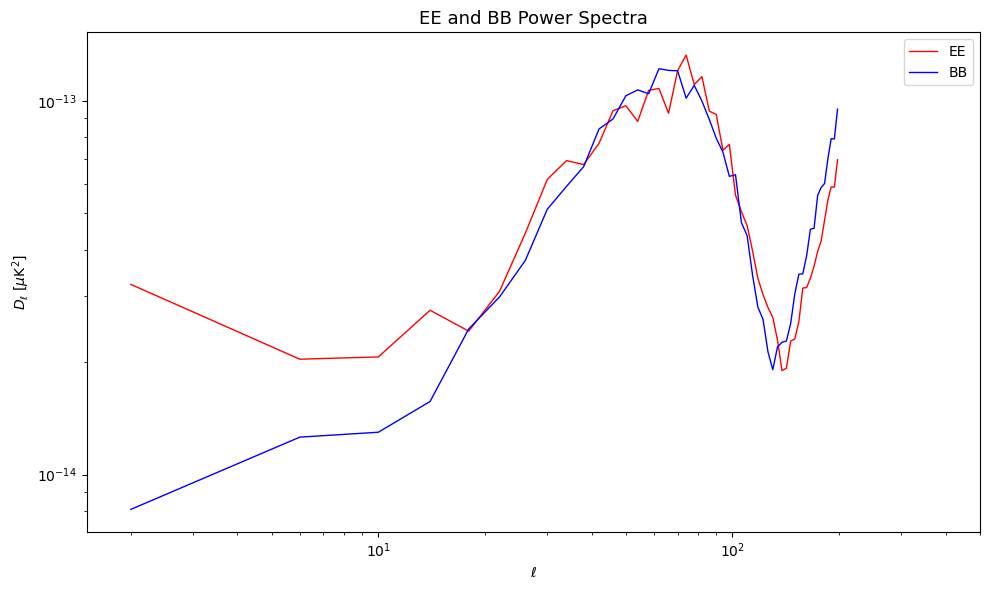

In [19]:
plt.figure(figsize=(10, 6))
factor = ells_uncoupled*(ells_uncoupled+1) /(2*np.pi)


plt.title(f'EE and BB Power Spectra', fontsize = 13)

plt.plot(ells_uncoupled, EE_PS * factor, color='r', linewidth=1, label=f'EE')
plt.plot(ells_uncoupled, BB_PS * factor, color='b', linewidth=1, label=f'BB')
    
plt.loglog()
plt.legend(fontsize=10)
plt.xlim(1.5, 500)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')


plt.tight_layout()
plt.show()

In [20]:
np.savetxt('PYSM_EEPS_NoSys.txt', EE_PS, fmt='%.21f')
np.savetxt('PYSM_BBPS_NoSys.txt', BB_PS, fmt='%.21f')

# r forecast

In [21]:
def cosmological_likelihood(Cls_, fsky, r_input, fisher):
    import bisect
    from fgbuster.cosmology import _get_Cl_cmb
    """
    This function returns the c.l. from
    the likelihood on r provided Cls
    :param Cls_: Cls^stat from comp sep
            note: they must start from l=2
    :param fsky: percentage of the sky to use
    :param r_input: assumed value of r
    :param fisher: return 68% confidence level on r or sigma(r) from fisher
    :return sigma_r: 68% confidence level on r or sigma from fisher
    """
    lmax = len(Cls_)
    ell = np.arange(2, lmax + 2)

    # values of r over which the likelihood is computed
    if r_input >= 0.005:
        r_max = 2*r_input
    else:
        r_max = 0.01
    r_v = np.linspace(0.000, r_max, num=10 ** 6)
    r_v = r_v.tolist()
    # add r_input in r_v
    if r_input not in r_v:
        bisect.insort(r_v, r_input)
    r_v = np.array(r_v)

    ClBBr1 = _get_Cl_cmb(0.0, 1.0)[2][2:lmax + 2]
    ClBBlens = _get_Cl_cmb(1.0, 0.0)[2][2:lmax + 2]
    Data = ClBBlens + Cls_ + _get_Cl_cmb(0.0, r_input)[2][2:lmax+2]

    if fisher:
        # computing sigma(r=r_input) from fisher
        F = np.sum((2 * ell + 1) * fsky / 2 * ClBBr1 ** 2 / Data ** 2)
        sigma_r_fisher = np.sqrt(1.0 / F)

        return sigma_r_fisher

    else:
        # gridding the likelihood
        logL = np.array([np.sum((2 * ell + 1) / 2 * fsky * (np.log(ClBBr1 * r_ + ClBBlens + Cls_)
                                                                + Data / (ClBBr1 * r_ + ClBBlens + Cls_))) for r_ in r_v])
        L = np.exp(-(logL - np.min(logL)))
        # computing sigma(r=r_input) as the 68% confidence level on r
        rs_pos = r_v[r_v > r_input]
        plike_pos = L[r_v > r_input]
        cum = np.cumsum(plike_pos)
        cum /= cum[-1]
        sigma_r = rs_pos[np.argmin(np.abs(cum - 0.68))]

    return sigma_r

In [22]:
def xForecast(components, instrument, d_fgs, lmin, lmax,
              Alens=1.0, r=0.001, make_figure=False,
              **minimize_kwargs):
    from fgbuster import  CMB, Dust, Synchrotron, algebra, mixingmatrix, observation_helpers
    import os.path as op
    import numpy as np
    import pylab as pl
    import healpy as hp
    import scipy as sp
    from fgbuster.algebra import comp_sep, W_dBdB, W_dB, W, _mmm, _utmv, _mmv
    from fgbuster.mixingmatrix import MixingMatrix
    from fgbuster.observation_helpers import standardize_instrument
    from fgbuster.cosmology import _get_Cl_noise,_get_Cl_cmb
    import inspect
    from time import time
    import six
    import numpy as np
    import scipy as sp
    import numdifftools
    from functools import reduce
   
    
    # Preliminaries
    instrument = standardize_instrument(instrument)
    nside = hp.npix2nside(d_fgs.shape[-1])
    n_stokes = d_fgs.shape[1]
    n_freqs = d_fgs.shape[0]
    invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
    mask = d_fgs[0, 0, :] != 0.
    fsky = mask.astype(float).sum() / mask.size
    ell = np.arange(lmin, lmax+1)
    #print('fsky = ', fsky)

    ############################################################################
    # 1. Component separation using the noise-free foregrounds templare
    # grab the max-L spectra parameters with the associated error bars
    #print('======= ESTIMATION OF SPECTRAL PARAMETERS =======')
    A = MixingMatrix(*components)
    A_ev = A.evaluator(instrument.frequency)
    A_dB_ev = A.diff_evaluator(instrument.frequency)

    x0 = np.array([x for c in components for x in c.defaults])
    if n_stokes == 3:  # if T and P were provided, extract P
        d_comp_sep = d_fgs[:, 1:, :]
    else:
        d_comp_sep = d_fgs

    res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0,
                   **minimize_kwargs)

    res.params = A.params
    res.s = res.s.T
    A_maxL = A_ev(res.x)
    A_dB_maxL = A_dB_ev(res.x)
    A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)

    #print('res.x = ', res.x)

    ############################################################################
    # 2. Estimate noise after component separation
    ### A^T N_ell^-1 A
    #print('======= ESTIMATION OF NOISE AFTER COMP SEP =======')
    i_cmb = A.components.index('CMB')
    Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]

    ############################################################################
    # 3. Compute spectra of the input foregrounds maps
    ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 
    #print ('======= COMPUTATION OF CL_FGS =======')
    if n_stokes == 3:  
        d_spectra = d_fgs
    else:  # Only P is provided, add T for map2alm
        d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
        d_spectra[:, 1:] = d_fgs

    # Compute cross-spectra
    almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
    Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
    for f1 in range(n_freqs):
        for f2 in range(n_freqs):
            if f1 > f2:
                Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
            else:
                Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

    Cl_fgs = Cl_fgs[..., lmin:] / fsky

    ############################################################################
    # 4. Estimate the statistical and systematic foregrounds residuals
    #print('======= ESTIMATION OF STAT AND SYS RESIDUALS =======')

    W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
    W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
    W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,
                         A.comp_of_dB, invN=invN)[:, :, i_cmb]
    V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)

    # Check dimentions
    assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
    assert (len(res.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

    # elementary quantities defined in Stompor, Errard, Poletti (2016)
    Cl_xF = {}
    Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
    Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
    Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
    Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
    Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

    # bias and statistical foregrounds residuals
    res.noise = Cl_noise
    res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
    res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
    res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

    ###############################################################################
    # 5. Plug into the cosmological likelihood
    #print ('======= OPTIMIZATION OF COSMO LIKELIHOOD =======')
    Cl_fid = {}
    Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
    Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
    Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

    res.BB = Cl_fid['BB']*1.0
    res.BuBu = Cl_fid['BuBu']*1.0
    res.BlBl = Cl_fid['BlBl']*1.0
    res.ell = ell
    if make_figure:
        fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
        ax = pl.gca()
        left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
        ax0 = fig.add_axes([left, bottom, width, height])
        ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
            r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

        ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
        ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGray', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
        ax.loglog(ell, res.stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
        ax.loglog(ell, res.bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
        ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
        ax.legend()
        ax.set_xlabel('$\ell$', fontsize=20)
        ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
        ax.set_xlim(lmin,lmax)

    ## 5.1. data 
    Cl_obs = Cl_fid['BB'] + Cl_noise
    dof = (2 * ell + 1) * fsky
    YY = Cl_xF['YY']
    tr_SigmaYY = np.einsum('ij, lji -> l', res.Sigma, YY)

    ## 5.2. modeling
    def cosmo_likelihood(r_):
        # S16, Appendix C
        Cl_model = Cl_fid['BlBl'] * Alens + Cl_fid['BuBu'] * r_ + Cl_noise
        dof_over_Cl = dof / Cl_model
        ## Eq. C3
        U = np.linalg.inv(res.Sigma_inv + np.dot(YY.T, dof_over_Cl))
        
        ## Eq. C9
        first_row = np.sum(dof_over_Cl * (
            Cl_obs * (1 - np.einsum('ij, lji -> l', U, YY) / Cl_model) 
            + tr_SigmaYY))
        second_row = - np.einsum(
            'l, m, ij, mjk, kf, lfi',
            dof_over_Cl, dof_over_Cl, U, YY, res.Sigma, YY)
        trCinvC = first_row + second_row
       
        ## Eq. C10
        first_row = np.sum(dof_over_Cl * (Cl_xF['yy'] + 2 * Cl_xF['yz']))
        ### Cyclicity + traspose of scalar + grouping terms -> trace becomes
        ### Yy_ell^T U (Yy + 2 Yz)_ell'
        trace = np.einsum('li, ij, mj -> lm',
                          Cl_xF['Yy'], U, Cl_xF['Yy'] + 2 * Cl_xF['Yz'])
        second_row = - _utmv(dof_over_Cl, trace, dof_over_Cl)
        trECinvC = first_row + second_row

        ## Eq. C12
        logdetC = np.sum(dof * np.log(Cl_model)) - np.log(np.linalg.det(U))

        return trCinvC + trECinvC + logdetC


    # Likelihood maximization
    r_grid = np.logspace(-5,0,num=500)
    logL = np.array([cosmo_likelihood(r_loc) for r_loc in r_grid])
    ind_r_min = np.argmin(logL)
    r0 = r_grid[ind_r_min]
    
    if ind_r_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    elif ind_r_min == len(r_grid)-1:
        bound_0 = r_grid[-2]
        bound_1 = 1.0

    else:
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    res_Lr = sp.optimize.minimize(cosmo_likelihood, [r0], bounds=[(bound_0,bound_1)], **minimize_kwargs)

    def sigma_r_computation_from_logL(r_loc):
        THRESHOLD = 1.00
        # THRESHOLD = 2.30 when two fitted parameters
        delta = np.abs( cosmo_likelihood(r_loc) - res_Lr['fun'] - THRESHOLD )
        return delta

    if res_Lr['x'] != 0.0:
        sr_grid = np.logspace(np.log10(res_Lr['x']), 0, num=25)
    else:
        sr_grid = np.logspace(-5,0,num=25)

    slogL = np.array([sigma_r_computation_from_logL(sr_loc) for sr_loc in sr_grid ])
    ind_sr_min = np.argmin(slogL)
    sr0 = sr_grid[ind_sr_min]

     

    
    if ind_sr_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = sr_grid[ind_sr_min+1]
        bound_1 = sr_grid[ind_sr_min-1]
    elif ind_sr_min == len(sr_grid)-1:

        bound_0 = sr_grid[-2]
        bound_1 = 1.0
    else:

        bound_0 = sr_grid[ind_sr_min-1]
        bound_1 = sr_grid[ind_sr_min+1]

    #res_sr = sp.optimize.minimize(sigma_r_computation_from_logL, sr0,
    #        bounds=[(bound_0.item(),bound_1.item())],
    #        **minimize_kwargs)

    
    
    
    
    
    
    sigma_r = cosmological_likelihood(Cl_obs, fsky, r0, True) #<----------------------------------------------------------------------------------- NEW SIGMA
    sigma_r = np.array([sigma_r])
    
    

    
    
    
    
    
    
    
    res.cosmo_params = {}
    res.cosmo_params['r'] = (res_Lr['x'], sigma_r) #res_sr['x']- res_Lr['x']


    ###############################################################################
    # 6. Produce figures
    if make_figure:
        #print ('======= GRIDDING COSMO LIKELIHOOD =======')
        r_grid = np.logspace(-4,-1,num=500)
        logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
        chi2 = logL - np.min(logL)
        ax0.semilogx( r_grid,  np.exp(-chi2), color='DarkOrange', linestyle='-', linewidth=2.0, alpha=0.8 )
        ax0.axvline(x=r, color='k', linestyle='--')
        ax0.set_ylabel(r'$\mathcal{L}(r)$', fontsize=20)
        ax0.set_xlabel(r'tensor-to-scalar ratio $r$', fontsize=20)
        pl.show()

    return res

In [23]:
# FISHER True

res = {}

res = xForecast(components, instrument_freq, full_array, 2, 2*nside-1, Alens=0.1, r=0.001, make_figure=False) 
res.cosmo_params['r'] = np.array(res.cosmo_params['r'])
r       = (res.cosmo_params['r'][0][0])
sigma_r = (res.cosmo_params['r'][1][0])
print(f'r = {r:.5f}, sigma_r = {sigma_r:.5f}')


r = 0.00100, sigma_r = 0.00110
